In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr

In [2]:
# Connect Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/DATA 6560/Data/Final dataset/merged_data (1).csv")

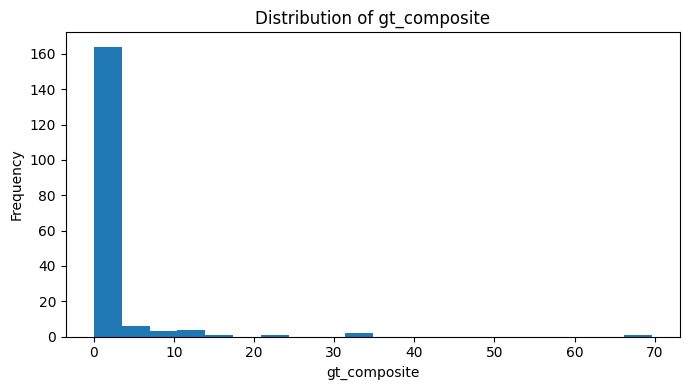

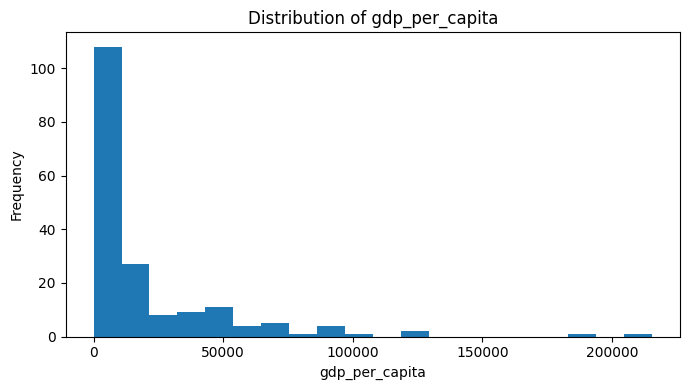

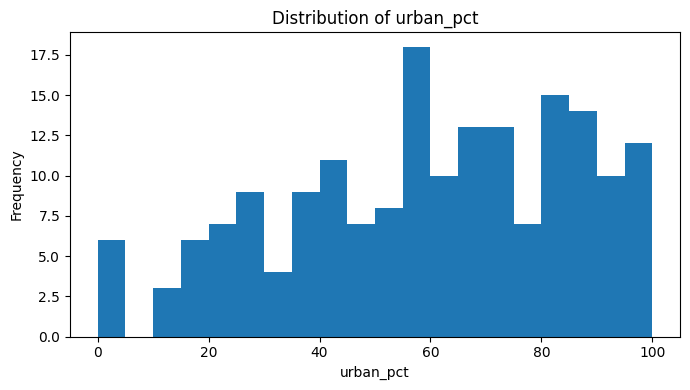

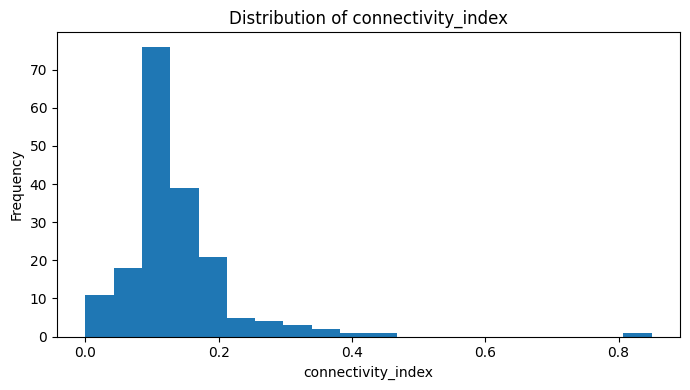

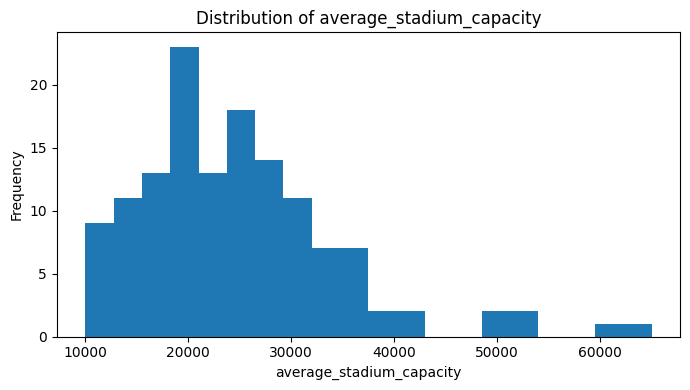

In [4]:
# List of variables for univariate analysis
variables = ["gt_composite", "gdp_per_capita", "urban_pct", "connectivity_index", "average_stadium_capacity"]

# Create histograms
for var in variables:
    plt.figure(figsize=(7,4))
    plt.hist(df[var].dropna(), bins=20)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

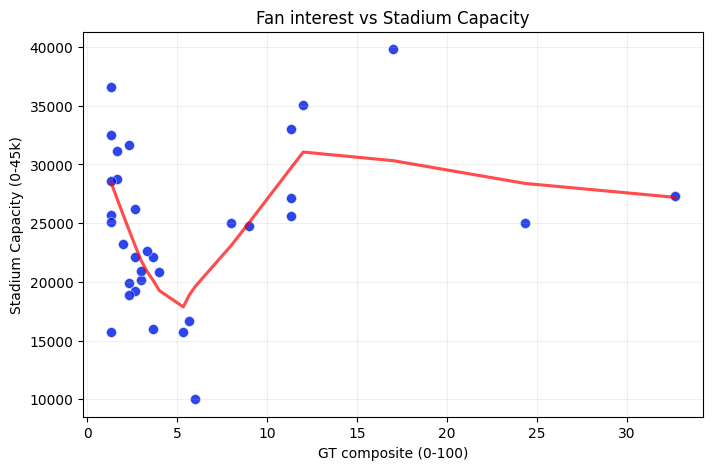

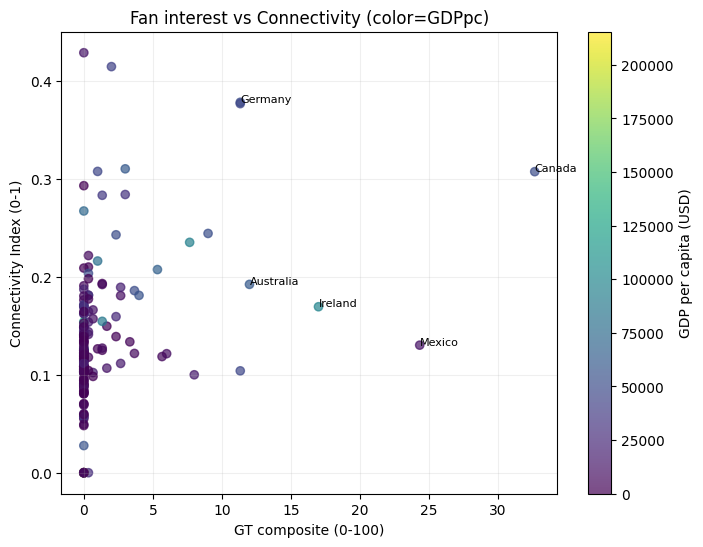

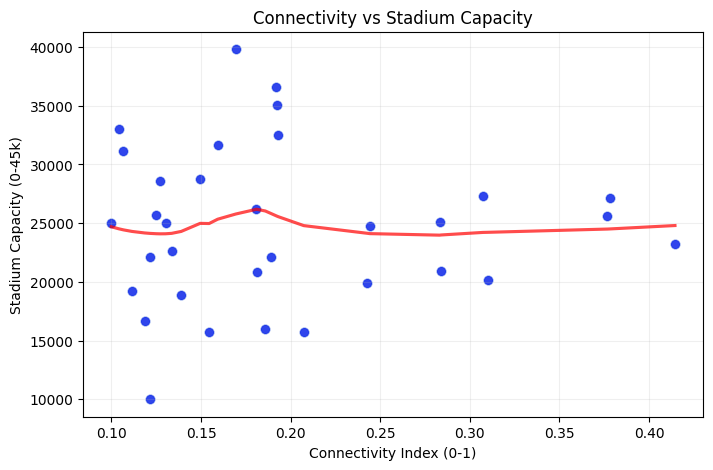

In [14]:
# Exclude obvious dominating outlier (United States) for some plots
df_no_outliers = df[(df['Country'] != 'United States') & (df['Country'] != 'Papua New Guinea')]

# Helper to show a scatter with regression (lowess for smoothing is useful)
def scatter_with_trend(x, y, data, title, xlabel=None, ylabel=None, logx=False, logy=False, color_by_gdp=False):
    plt.figure(figsize=(8,5))
    d = data.copy()

    if logx:
        d = d[d[x] > 0].copy()
        d[x+'_log'] = np.log10(d[x])
        xcol = x+'_log'
        xlabel = (xlabel or x) + " (log10)"
    else:
        xcol = x
    if logy:
        d = d[d[y] > 0].copy()
        d[y+'_log'] = np.log10(d[y])
        ycol = y+'_log'
        ylabel = (ylabel or y) + " (log10)"
    else:
        ycol = y

    # Regression line
    sns.regplot(
        x=xcol, y=ycol, data=d,
        scatter_kws={'s':40, 'alpha':0.6},
        lowess=True, line_kws={'color':'red', 'alpha':0.7}
    )

    # Scatter points, optionally colored by GDP
    if color_by_gdp:
        sns.scatterplot(
            x=xcol, y=ycol, data=d,
            hue='gdp_per_capita', palette='viridis', legend=False, s=50, alpha=0.6
        )
    else:
        sns.scatterplot(
            x=xcol, y=ycol, data=d, color='blue', s=50, alpha=0.6
        )

    plt.title(title)
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel or y)
    plt.grid(alpha=0.2)

# Filter out rows with GT composite = 0
df_filtered = df_no_outliers[df_no_outliers['gt_composite'] > 1]

# 1) Fan vs Stadium Capacity
scatter_with_trend("gt_composite", "average_stadium_capacity", df_filtered,
                   title="Fan interest vs Stadium Capacity",
                   xlabel="GT composite (0-100)", ylabel="Stadium Capacity (0-45k)", color_by_gdp=False )


# 2) 2D coloured by GDP: Fan vs Connectivity, colour = GDP per capita
plt.figure(figsize=(8,6))
d = df_no_outliers.copy()

# Scatter without size variation
plt.scatter(
    d['gt_composite'],
    d['connectivity_index'],
    c=d['gdp_per_capita'],
    cmap='viridis',
    alpha=0.7  # keep some transparency
)

plt.colorbar(label='GDP per capita (USD)')
plt.xlabel('GT composite (0-100)')
plt.ylabel('Connectivity Index (0-1)')
plt.title('Fan interest vs Connectivity (color=GDPpc)')

# Annotate top 5 GT composite
for i, r in d.nlargest(5, 'gt_composite').iterrows():
    plt.text(r['gt_composite'], r['connectivity_index'], r['Country'], fontsize=8)

plt.grid(alpha=0.2)
plt.show()

# 3) Stadium Capacity vs Connectivity Index
scatter_with_trend("connectivity_index", "average_stadium_capacity", df_filtered,
                   title="Connectivity vs Stadium Capacity",
                   xlabel="Connectivity Index (0-1)", ylabel="Stadium Capacity (0-45k)", color_by_gdp=False )


In [15]:
# The column for splitting is 'gdp_per_capita'
split_column = 'gdp_per_capita'

# Calculate the median for splitting (more robust than mean)
gdp_median = df[split_column].median()
print(f"Median GDP per Capita: {gdp_median:,.2f}")

# Create the subgroup column
# High-GDP Countries: gdp_per_capita >= median
# Low-GDP Countries: gdp_per_capita < median
df['gdp_subgroup'] = df[split_column].apply(
    lambda x: 'High-GDP Countries' if x >= gdp_median else 'Low-GDP Countries'
)

# Columns to compare across subgroups
comparison_columns = ['gt_composite', 'connectivity_index', 'gdp_per_capita']

# Calculate the mean of the comparison columns for each subgroup
subgroup_comparison = df.groupby('gdp_subgroup')[comparison_columns].mean()

# Rename columns for clarity in the final output
subgroup_comparison = subgroup_comparison.rename(columns={
    'gt_composite': 'Avg_NFL_Interest_Index',
    'connectivity_index': 'Avg_Connectivity_Index',
    'gdp_per_capita': 'Avg_GDP_Per_Capita'
})

# Display the results
print("\nSubgroup Comparison (Mean Values):")
print(subgroup_comparison)

Median GDP per Capita: 6,752.03

Subgroup Comparison (Mean Values):
                    Avg_NFL_Interest_Index  Avg_Connectivity_Index  \
gdp_subgroup                                                         
High-GDP Countries                 2.92674                0.159350   
Low-GDP Countries                  0.63370                0.115237   

                    Avg_GDP_Per_Capita  
gdp_subgroup                            
High-GDP Countries        37727.980608  
Low-GDP Countries          2725.256284  
